----
### COMPILE PREDICTION RESULTS
----

In [131]:
from export_catalog import *

### the whole loop may take a couple of hours, can be broken down parallel
for year in range(2010,2024):

### i/o configuration
    old_version = "1.2.0"
    new_version = "1.2.0"
    old_filename_suffix = f"_{year}"
    new_filename_subfix = f"_{year}"
    datalist_dir = "/Users/junsu/Documents/data_gcmt.pkl"
    event_filter = ""
    result_csv_filenames = glob.glob(f"./updeANMO_shift5_pred_catalog_*{year}/*_outputs/X_prediction_results.csv")

    old_catalog_dir = f"./globocat_{old_version}{old_filename_suffix}.xml"
    new_catalog_dir = f"./globocat_{new_version}{new_filename_subfix}.xml"
    if not os.path.exists(old_catalog_dir):
        print("A new catalog will be created:", new_catalog_dir)
        globocat = GlobalCatalog()
    else:
        start_time = time.time()
        print('Loading catalog:', old_catalog_dir, end="\r")
        globocat = GlobalCatalog()
        globocat.events = read_events(old_catalog_dir).events
        load_time = time.time() - start_time
        print(f"\nCatalog is loaded in {load_time:.1f} seconds.")


### update catalog and save as new file
    globocat.resource_id=str(f"quakeml:jun.su/globocat_{new_version}")
    globocat.creation_info=CreationInfo(author="Jun Su", version=new_version, creation_time=UTCDateTime.now())

    with open(datalist_dir, 'rb') as f: datalist = pickle.load(f)
    globocat.update_catalog(datalist, result_csv_filenames, new_version)
    print('Saving file...', end="\r")
    globocat.write(new_catalog_dir, format='QUAKEML')
    print("Catalog is saved:", new_catalog_dir)
    
# ### export pandas dataframe
#     df = globocat.get_dataframe(load_station_dict="station_dict.json", include_id=True)
#     df.to_pickle(f'updeANMO_shift5_catalog_{year}_plot.pkl')

KeyboardInterrupt: 

In [4]:
from export_catalog import *
old_version = "1.1.1"
new_version = "1.1.1"
old_filename_suffix = "_2020"
new_filename_subfix = "_2020"
datalist_dir = "/Users/junsu/Documents/data_gcmt.pkl"
event_filter = ""
result_csv_filenames = glob.glob("./updeANMO_shift5_pred_catalog_*2020/*_outputs/X_prediction_results.csv")

old_catalog_dir = f"./globocat_{old_version}{old_filename_suffix}.xml"
new_catalog_dir = f"./globocat_{new_version}{new_filename_subfix}.xml"
if not os.path.exists(old_catalog_dir):
    print("A new catalog will be created:", new_catalog_dir)
    globocat = GlobalCatalog()
else:
    start_time = time.time()
    print('Loading catalog:', old_catalog_dir, end="\r")
    globocat = GlobalCatalog()
    globocat.events = read_events(old_catalog_dir).events
    load_time = time.time() - start_time
    print(f"\nCatalog is loaded in {load_time:.1f} seconds.")

A new catalog will be created: ./globocat_1.1.1_2020.xml


In [1]:
globocat.resource_id=str(f"quakeml:jun.su/globocat_{new_version}")
globocat.creation_info=CreationInfo(author="Jun Su", version=new_version, creation_time=UTCDateTime.now())

with open(datalist_dir, 'rb') as f: datalist = pickle.load(f)
globocat.update_catalog(datalist, result_csv_filenames, new_version)
print('Saving file...', end="\r")
globocat.write(new_catalog_dir, format='QUAKEML')
print("Catalog is saved:", new_catalog_dir)

NameError: name 'new_version' is not defined

----
### DATA VISUALIZATION
###### GEOGRAPHICAL DISTRIBUTION
----

In [9]:
## deprecated
import json
from GeoPoint import *
from picker import flatten_list
from export_catalog import get_station_dict

with open('station_dict.json', 'r') as f:
    station_dict = json.load(f)

def get_dataframe(cat, include_id=False):
    return pd.DataFrame([flatten_list([
                        arrival.resource_id.id.split('-')[-3].split('_')[:2],
                        arrival.phase,
                        round(arrival.time_residual, 2),
                        arrival.pick_id.get_referred_object().time_errors.confidence_level,
                        round(arrival.distance, 4),
                        round(arrival.azimuth, 2),
                        round(arrival.pick_id.get_referred_object().backazimuth, 2),
                        list(midpoint(GeoPoint(
                                lat = ev.preferred_origin().latitude,
                                lon = ev.preferred_origin().longitude
                            ), GeoPoint(
                                lat = station_dict[f"{'.'.join(arrival.resource_id.id.split('-')[-3].split('_')[:2])}"]['latitude'],
                                lon = station_dict[f"{'.'.join(arrival.resource_id.id.split('-')[-3].split('_')[:2])}"]['longitude']
                            )).get_latlon('deg', precision=3)
                        ),
                        arrival.resource_id.id.split('/')[-1] if include_id else []
                    ]) for ev in cat for arrival in ev.preferred_origin().arrivals ],
                # columns=['network', 'station', 'phase', 'time_residual', 'probability','distance', 'azimuth', 'backazimuth', 'midpoint_lat', 'midpoint_lon', 'arrival_id'],
                columns=['network', 'station', 'phase', 'anomaly', 'probability','gcarc', 'azimuth', 'backazimuth', 'turning_lat', 'turning_lon', 'arrival_id'][:(None if include_id else -1)],
                )
# df = get_dataframe(globocat, include_id=False)
# df
# df.to_pickle(f'updeANMO_shift5_catalog_2020_plot.pkl')

In [1]:
from obspy import read_events

globocat = read_events("globocat_1.2.0_20??.xml")
globocat

Exception: No file matching file pattern: globocat_1.2.0_20??.xml

In [36]:
globocat[0].preferred_origin().latitude

-37.27

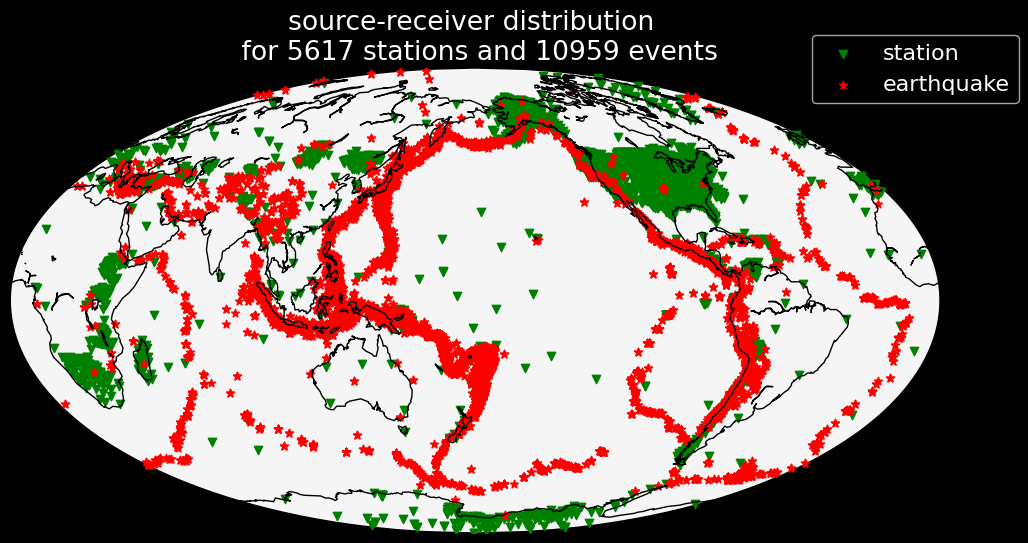

In [42]:
import glob
import numpy as np
import pandas as pd
from cmcrameri import cm
from obspy import UTCDateTime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

df = pd.concat([pd.read_pickle(filename) for filename in glob.glob(f'updeANMO_shift5_catalog_*_plot.pkl')], ignore_index=True)

st_lats = [ value['latitude'] for value in station_dict.values() ]
st_lons = [ value['longitude']  for value in station_dict.values() ]
ev_lats = [ ev.preferred_origin().latitude for ev in globocat ]
ev_lons = [ ev.preferred_origin().longitude for ev in globocat ]

# phase ='p'
plt.rcParams["font.size"] = 16
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,8))
map = Basemap(projection='moll',lon_0=-180,resolution='c',ax=ax)
# map.drawmapboundary(fill_color='white'

x, y = map(st_lons, st_lats)
ax.scatter(x, y, c='g', marker='v')
x, y = map(ev_lons, ev_lats)
ax.scatter(x, y, c='r', marker='*')

map.drawmapboundary(fill_color='whitesmoke')
map.drawcoastlines()
ax.legend(['station', 'earthquake'], loc='lower left', bbox_to_anchor=(0.85, 0.9))
plt.title(f'source-receiver distribution \n for {len(st_lons)} stations and {len(ev_lons)} events')

# plt.show()
plt.savefig('src-sta_geo.png', bbox_inches="tight")

In [21]:
lats[0]

42.633202

----
### DATA VISUALIZATION
###### SLOPE ANALYSIS
----

In [26]:
import glob
import pandas as pd
df = pd.concat([pd.read_pickle(filename) for filename in glob.glob(f'updeANMO_shift5_catalog_*_plot.pkl')], ignore_index=True)

In [12]:
[pd.read_pickle(filename) for filename in glob.glob(f'/Users/jun/Downloads/result_table_centroid/updeANMO_shift5_catalog_apr*2_plot.pkl')]

[      network station phase                 arrival_time  anomaly  \
 0          US     ELK     P  2022-04-13T02:44:57.716361Z    -3.72   
 1          US    TPNV     P  2022-04-13T02:44:53.409169Z     0.99   
 2          PB    B202     P  2022-04-13T02:44:08.227669Z   -40.04   
 3          TW    SSLB     P  2022-04-13T02:42:02.175825Z     6.82   
 4          TW    SSLB     S  2022-04-13T02:49:53.925825Z    -2.24   
 ...       ...     ...   ...                          ...      ...   
 16927      II    SHEL     S  2022-04-09T16:11:22.418313Z    33.63   
 16928      C1    AY05     P  2022-04-09T16:06:26.981026Z   232.24   
 16929      C1    AY05     S  2022-04-09T16:13:54.731026Z     6.35   
 16930      IU    KMBO     P  2022-04-09T15:58:18.739105Z    -6.05   
 16931      IU    KMBO     S  2022-04-09T16:05:52.489105Z     2.26   
 
        probability    gcarc  azimuth backazimuth  turning_lat  turning_lon  \
 0             0.28  90.2690    48.02        None       17.080     -160.095   


In [16]:
import glob
import pandas as pd
df = pd.concat([pd.read_pickle(filename) for filename in glob.glob(f'/Users/jun/Downloads/result_table_centroid/updeANMO_shift5_catalog_*_plot.pkl')], ignore_index=True)

count    2.052100e+06
mean     2.409381e-01
std      4.877431e+00
min     -1.999000e+01
25%     -2.060000e+00
50%      7.000000e-02
75%      2.360000e+00
max      1.999000e+01
Name: anomaly, dtype: float64
count    1.965807e+06
mean     8.486482e-01
std      6.801280e+00
min     -2.999000e+01
25%     -2.670000e+00
50%      9.400000e-01
75%      4.530000e+00
max      2.999000e+01
Name: anomaly, dtype: float64


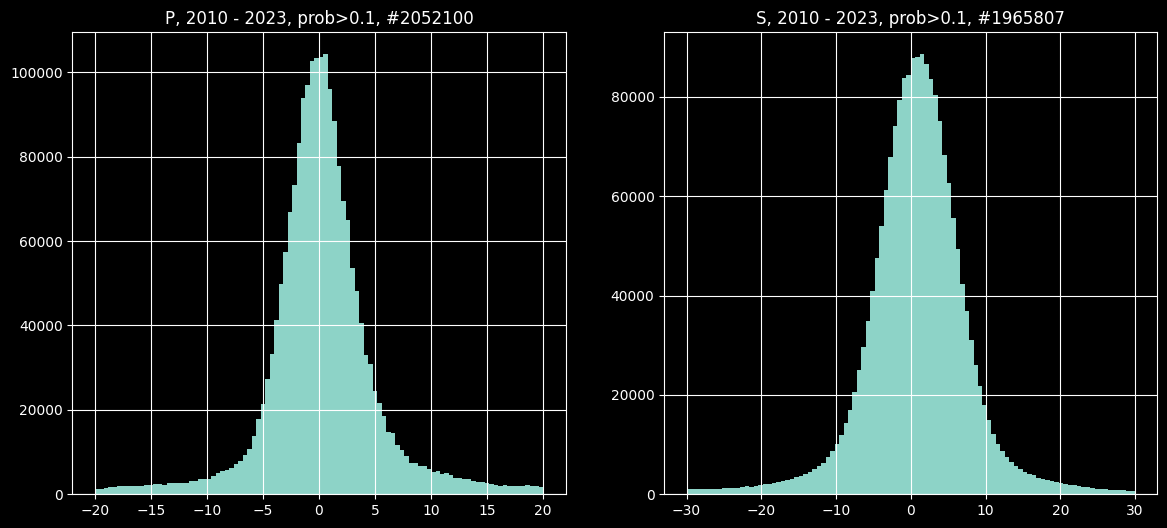

In [2]:
import matplotlib.pyplot as plt
p_thres = 0.1
s_thres = 0.1

plt.style.use('dark_background')
plt.figure(figsize=(14,6))
plt.subplot(121)
# for i in range(5,6,1):
    # p_thres = i/10
df_filtered = df.loc[(abs(df['anomaly'])<20) & (df['phase']=='P') & (df['probability']>p_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=1)
# plt.ylim([0,5000])
plt.title(f"P, 2010 - 2023, prob>{p_thres}, #{len(df_filtered)}")
print(df_filtered.describe())
plt.subplot(122)
# for i in range(3,4,1):
#     s_thres = i/10
df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='S') & (df['probability']>s_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=1)
# plt.ylim([0,5000])
plt.title(f"S, 2010 - 2023, prob>{s_thres}, #{len(df_filtered)}")
print(df_filtered.describe())

count     2119961.00
unique       5999.00
top            -0.19
freq         2955.00
Name: anomaly, dtype: float64
count     1974344.0
unique       5999.0
top             0.1
freq         1567.0
Name: anomaly, dtype: float64


Text(0.5, 0, 'Travel time residual (s)')

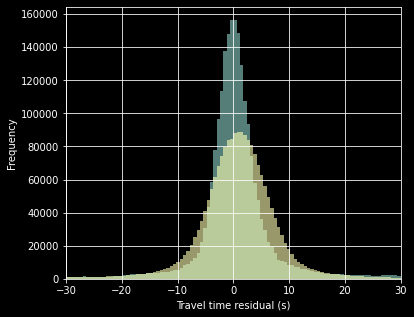

In [13]:
import matplotlib.pyplot as plt
p_thres = 0.1
s_thres = 0.1

plt.style.use('dark_background')
plt.figure(figsize=(6,5))
df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='P') & (df['probability']>p_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=0.6)
# plt.title(f"P, 2010 - 2023, prob>{p_thres}, #{len(df_filtered)}")
print(df_filtered.describe())
df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='S') & (df['probability']>s_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=0.6)
# plt.title(f"S, 2010 - 2023, prob>{s_thres}, #{len(df_filtered)}")
print(df_filtered.describe())
plt.xlim([-30, 30])
plt.ylabel('Frequency')
plt.xlabel('Travel time residual (s)')

count    1.861313e+06
mean     3.005442e-01
std      5.310127e+00
min     -2.999000e+01
25%     -1.940000e+00
50%      6.000000e-02
75%      2.210000e+00
max      2.999000e+01
Name: anomaly, dtype: float64
count    243842.000000
mean          1.201533
std          11.454699
min         -29.990000
25%          -4.980000
50%           0.950000
75%           7.170000
max          29.990000
Name: anomaly, dtype: float64


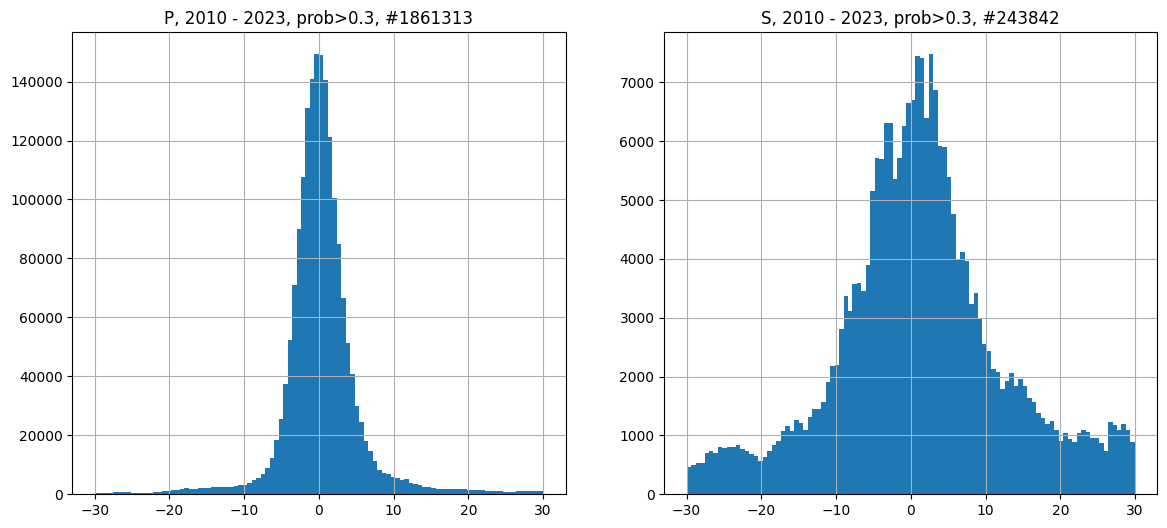

In [8]:
import matplotlib.pyplot as plt
p_thres = 0.3
s_thres = 0.3

plt.figure(figsize=(14,6))
plt.subplot(121)
# for i in range(5,6,1):
    # p_thres = i/10
df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='P') & (df['probability']>p_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=1)
# plt.ylim([0,5000])
plt.title(f"P, 2010 - 2023, prob>{p_thres}, #{len(df_filtered)}")
print(df_filtered.describe())
plt.subplot(122)
# for i in range(3,4,1):
#     s_thres = i/10
df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='P') & (df['probability']<p_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=1)
# plt.ylim([0,5000])
plt.title(f"S, 2010 - 2023, prob>{s_thres}, #{len(df_filtered)}")
print(df_filtered.describe())

In [14]:
import pandas as pd
guy_s = pd.read_csv("~/Downloads/S.Guy.76-99.table", delim_whitespace=True)
guy_p = pd.read_csv("~/Downloads/P.Guy.76-99.table", delim_whitespace=True)
christine_p = pd.read_csv("~/Downloads/drive-download-20220512T014633Z-001/Pcomb.4.07.09.table", delim_whitespace=True)
christine_s = pd.read_csv("~/Downloads/drive-download-20220512T014633Z-001/Scomb.4.07.09.table", delim_whitespace=True)


count     1185516.00
unique       5920.00
top            -0.19
freq         2119.00
Name: anomaly, dtype: float64
count     1429306.0
unique       5975.0
top             0.9
freq         1256.0
Name: anomaly, dtype: float64


Text(0.5, 1.0, 'S arrival distribution')

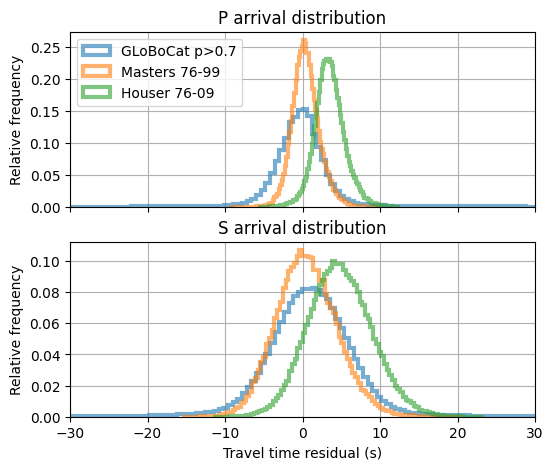

In [52]:
import matplotlib.pyplot as plt
p_thres = 0.7
s_thres = 0.5

# plt.style.use('dark_background')
plt.style.use('default')
fig, axs = plt.subplots(2,1, figsize=(6,5), sharex=True)

df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='P') & (df['probability']>p_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=0.6, histtype=u'step', linewidth=3, density=True, label=f'GLoBoCat p>{p_thres}', ax=axs[0])
# plt.title(f"P, 2010 - 2023, prob>{p_thres}, #{len(df_filtered)}")
print(df_filtered.describe())
guy_p['residual'].hist(bins=100, alpha=0.6, histtype=u'step', linewidth=3, density=True, label='Masters 76-99', ax=axs[0])
christine_p['residual'].hist(bins=100, alpha=0.6, histtype=u'step', linewidth=3, density=True, label='Houser 76-09', ax=axs[0])

# df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='S') & (df['probability']>s_thres) & (df['gcarc']>0)]['anomaly']
# df_filtered.hist(bins=100, alpha=0.6)
# # plt.title(f"S, 2010 - 2023, prob>{s_thres}, #{len(df_filtered)}")
# print(df_filtered.describe())
axs[0].legend()
axs[0].set_xlim([-30, 30])
axs[0].set_ylabel('Relative frequency')
# axs[0].set_xlabel('Travel time residual (s)')
axs[0].set_title('P arrival distribution')

# plt.figure(figsize=(6,5))
df_filtered = df.loc[(abs(df['anomaly'])<30) & (df['phase']=='S') & (df['probability']>s_thres) & (df['gcarc']>0)]['anomaly']
df_filtered.hist(bins=100, alpha=0.6, histtype=u'step', linewidth=3, density=True, label=f'GLoBoCat p>{s_thres}', ax=axs[1])
# plt.title(f"P, 2010 - 2023, prob>{p_thres}, #{len(df_filtered)}")
print(df_filtered.describe())
guy_s['residual'].hist(bins=100, alpha=0.6, histtype=u'step', linewidth=3, density=True, label='Masters 76-99', ax=axs[1])
(christine_s['residual']-christine_s['ellipcor']-christine_s['crustcor']).hist(bins=100, alpha=0.6, histtype=u'step', linewidth=3, density=True, label='Houser 76-09', ax=axs[1])

# plt.xlim([-30, 30])
axs[1].set_ylabel('Relative frequency')
axs[1].set_xlabel('Travel time residual (s)')
# axs[1].legend()
axs[1].set_title('S arrival distribution')

count     1429306.0
unique       5975.0
top             0.9
freq         1256.0
Name: anomaly, dtype: float64


Text(0.5, 1.0, 'S arrival distribution')

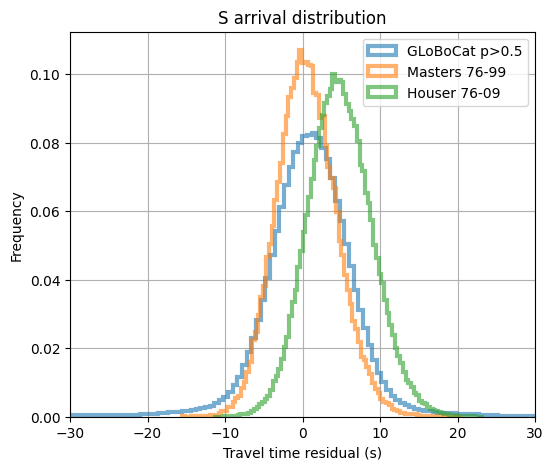

In [19]:
christine_s

phase  residual  error  ellipcor  crustcor     obstim    calctim  year  \
0          S    13.867    3.0     0.286    -2.074  1012.9342   999.0670  1976   
1          S    10.048    2.0     0.477     0.373  1349.8518  1339.8038  1976   
2          S     0.897    2.0     0.711     0.392   799.3965   798.4993  1976   
3          S     8.299    3.0     0.466    -2.016   830.3830   822.0845  1976   
4          S     7.061    2.0     0.604    -2.205   784.7881   777.7273  1976   
...      ...       ...    ...       ...       ...        ...        ...   ...   
210728     S     5.107    3.0     0.522     0.535  1502.8347  1497.7273  2009   
210729     S     8.784    3.0    -0.296     1.020  1437.6843  1428.8999  2009   
210730     S     7.466    3.0     0.042     0.812   564.6779   557.2115  2009   
210731     S     9.925    3.0    -0.467     0.726   693.3105   683.3853  2009   
210732     S     6.908    3.0    -0.506     0.182   675.9410   669.0327  2009   

        day  hour  min   sec  eqlat   eqlon  eqdep station  stalat   stalon  \
0         1     1   29  39.6 -28.61 -177.64   59.0     KIP  21.423  201.985   
1         1     9    4  44.6 -16.59 -172.85   33.0    ANMO  34.946  253.543   
2         1     9    4  44.6 -16.59 -172.85   33.0     CTA -20.088  146.254   
3         1     9    4  44.6 -16.59 -172.85   33.0     KIP  21.423  201.985   
4         1    18   43  38.2 -16.79  167.25   25.0    GUMO  13.588  144.866   
...     ...   ...  ...   ...    ...     ...    ...     ...     ...      ...   
210728  364    18   48  57.7  32.44 -115.17    9.0     SSE  31.096  121.187   
210729  364    18   48  57.7  32.44 -115.17    9.0     TLY  51.681  103.644   
210730  364    18   48  57.7  32.44 -115.17    9.0    USIN  37.965  272.334   
210731  364    18   48  57.7  32.44 -115.17    9.0     WHY  60.660  225.119   
210732  364    18   48  57.7  32.44 -115.17    9.0    YKW3  62.562  245.390   

          dist      azi  
0       53.227   22.997  
1       81.162   49.622  
2       38.908  258.446  
3       40.482   21.559  
4       37.417  322.453  
...        ...      ...  
210728  97.324  313.943  
210729  89.568  337.030  
210730  23.097   68.504  
210731  31.056  341.217  
210732  30.140    0.517  

[210733 rows x 20 columns]

In [32]:
from obspy.taup import TauPyModel
from obspy.geodetics.base import gps2dist_azimuth, kilometers2degrees
model = TauPyModel(model="prem")
caltime_diff = []

for idx, row in christine_s.sample(n=30000).iterrows():
    azimuths = gps2dist_azimuth(
                            lat1=row['eqlat'],
                            lon1=row['eqlon'],
                            lat2=row['stalat'],
                            lon2=row['stalon'],
                            )
    distance = kilometers2degrees(azimuths[0]/1000)
    prem_arrival_time = model.get_travel_times(row['eqdep'], distance, ["S"])
    if prem_arrival_time:
        caltime_diff.append(prem_arrival_time[0].time-row['calctim'])

In [41]:
pd.Series(caltime_diff).describe()

count    30000.000000
mean         0.036562
std          1.003653
min         -2.654633
25%         -0.645631
50%         -0.001228
75%          0.716958
max          3.473024
dtype: float64

<AxesSubplot:>

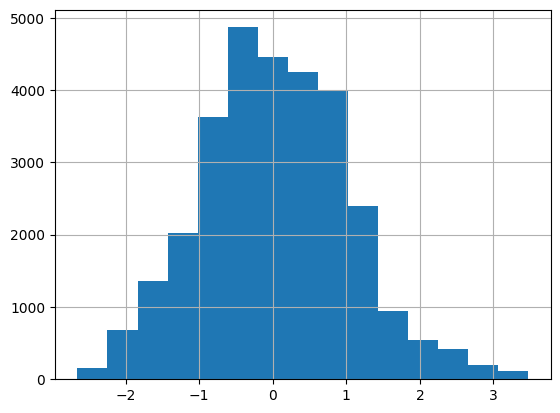

In [40]:
pd.Series(caltime_diff).hist(bins=15)

In [15]:
df_example = df[:10]
["-".join(arrival_id.split('-')[1:4]) for arrival_id in df_example['arrival_id']]

['2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z',
 '2010-09-09T07:28:05.600Z']

In [62]:
df_year = df.loc[[int(arrival_id.split('-')[1]) == 2020 for arrival_id in df['arrival_id'].values]]
df_year.loc[(df_year['phase'] == 'S') & (df_year['network'] == 'US') & (df_year['probability'] < 0.3)]

Empty DataFrame
Columns: [network, station, phase, anomaly, probability, gcarc, azimuth, backazimuth, turning_lat, turning_lon, arrival_id]
Index: []

In [ ]:
import matplotlib.pyplot as plt
from export_catalog import plot_depthslice
    
p_thres = 0.1
s_thres = 0.1
gcarc_interval = 10
subplot = 420
plt.figure(figsize=(24,30))
plt.rcParams["font.size"] = 16

for top_gcarc in range(70, 100, 10):
    subplot+=1; plt.subplot(subplot)
    plot_depthslice(phase = 'p',
                    value = 'anomaly',
                    gcarc_range = (top_gcarc,top_gcarc+gcarc_interval),
                    fidelity_func = lambda p: p-p_thres,
                    value_constraint = lambda x: abs(x)<15,
                    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=False,
                    demean=True,
                    plot_legend=True
                    )
    subplot+=1; plt.subplot(subplot)
    plot_depthslice(phase = 's',
                    value = 'anomaly',
                    gcarc_range = (top_gcarc,top_gcarc+gcarc_interval),
                    fidelity_func = lambda p: p-s_thres,
                    value_constraint = lambda x: abs(x)<30,
                    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=False,
                    demean=True,
                    )
    # plt.subplots_adjust(wspace=0.1)
    # plt.savefig(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png", bbox_inches="tight")
plt.show()

In [6]:
import pandas as pd
df = pd.read_pickle('updeANMO_shift5_catalog_2020_plot.pkl')
df.drop(['anomaly_rev', 'anomaly_isc'], axis='columns').to_pickle("test_summary_ray.pkl")

In [ ]:
import matplotlib.pyplot as plt
from export_catalog import plot_depthslice
    
p_thres = 0.7
s_thres = 0.5
gcarc_interval = 5

for top_gcarc in range(50, 70, 5):
    plt.figure(figsize=(24,8))
    plt.rcParams["font.size"] = 16

    plt.subplot(121)
    plot_depthslice(phase = 'p',
                    value = 'anomaly',
                    gcarc_range = (top_gcarc,top_gcarc+gcarc_interval),
                    fidelity_func = lambda p: p-p_thres,
                    value_constraint = lambda x: abs(x)<15,
                    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=True,
                    demean=True,
                    plot_legend=True
                    )
    plt.subplot(122)
    plot_depthslice(phase = 's',
                    value = 'anomaly',
                    gcarc_range = (top_gcarc,top_gcarc+gcarc_interval),
                    fidelity_func = lambda p: p-s_thres,
                    value_constraint = lambda x: abs(x)<30,
                    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=True,
                    demean=True,
                    )
    plt.subplots_adjust(wspace=0.1)
    plt.savefig(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png", bbox_inches="tight")
# plt.show()

In [ ]:
from IPython.display import Image
top_gcarc = 50
gcarc_interval = 5
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")


In [ ]:
top_gcarc = 55
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 60
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 65
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 70
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 75
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 80
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 85
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 90
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
top_gcarc = 95
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

In [ ]:
from IPython.display import Image
top_gcarc = 35; gcarc_interval = 5
Image(f"qc_rayavg.{top_gcarc}-{top_gcarc+gcarc_interval}.png")

----
### DATA VISUALIZATION
###### SLOPE ANALYSIS
----

In [5]:
from export_catalog import plot_depthslice, plot_ratio
p_thres = 0.7
s_thres = 0.5

get_p_table = lambda gcarc_range: plot_depthslice(phase = 'p',
                    value = 'anomaly',
                    gcarc_range = gcarc_range,
                    fidelity_func = lambda p: p-p_thres,
                    value_constraint = lambda x: abs(x)<20,
                    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=True,
                    demean=True,
                    plot=False
                )
get_s_table = lambda gcarc_range: plot_depthslice(phase = 's',
                    value = 'anomaly',
                    gcarc_range = gcarc_range,
                    fidelity_func = lambda p: p-s_thres,
                    value_constraint = lambda x: abs(x)<30,
                    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
                    summary_ray=True,
                    demean=True,
                    plot=False
                )

47276 points fit the conditions
79715 points fit the conditions
56312 points fit the conditions
85177 points fit the conditions
67088 points fit the conditions
92740 points fit the conditions
77180 points fit the conditions
98717 points fit the conditions
90068 points fit the conditions
113681 points fit the conditions
114105 points fit the conditions
139676 points fit the conditions
141698 points fit the conditions
169889 points fit the conditions
137753 points fit the conditions
140893 points fit the conditions


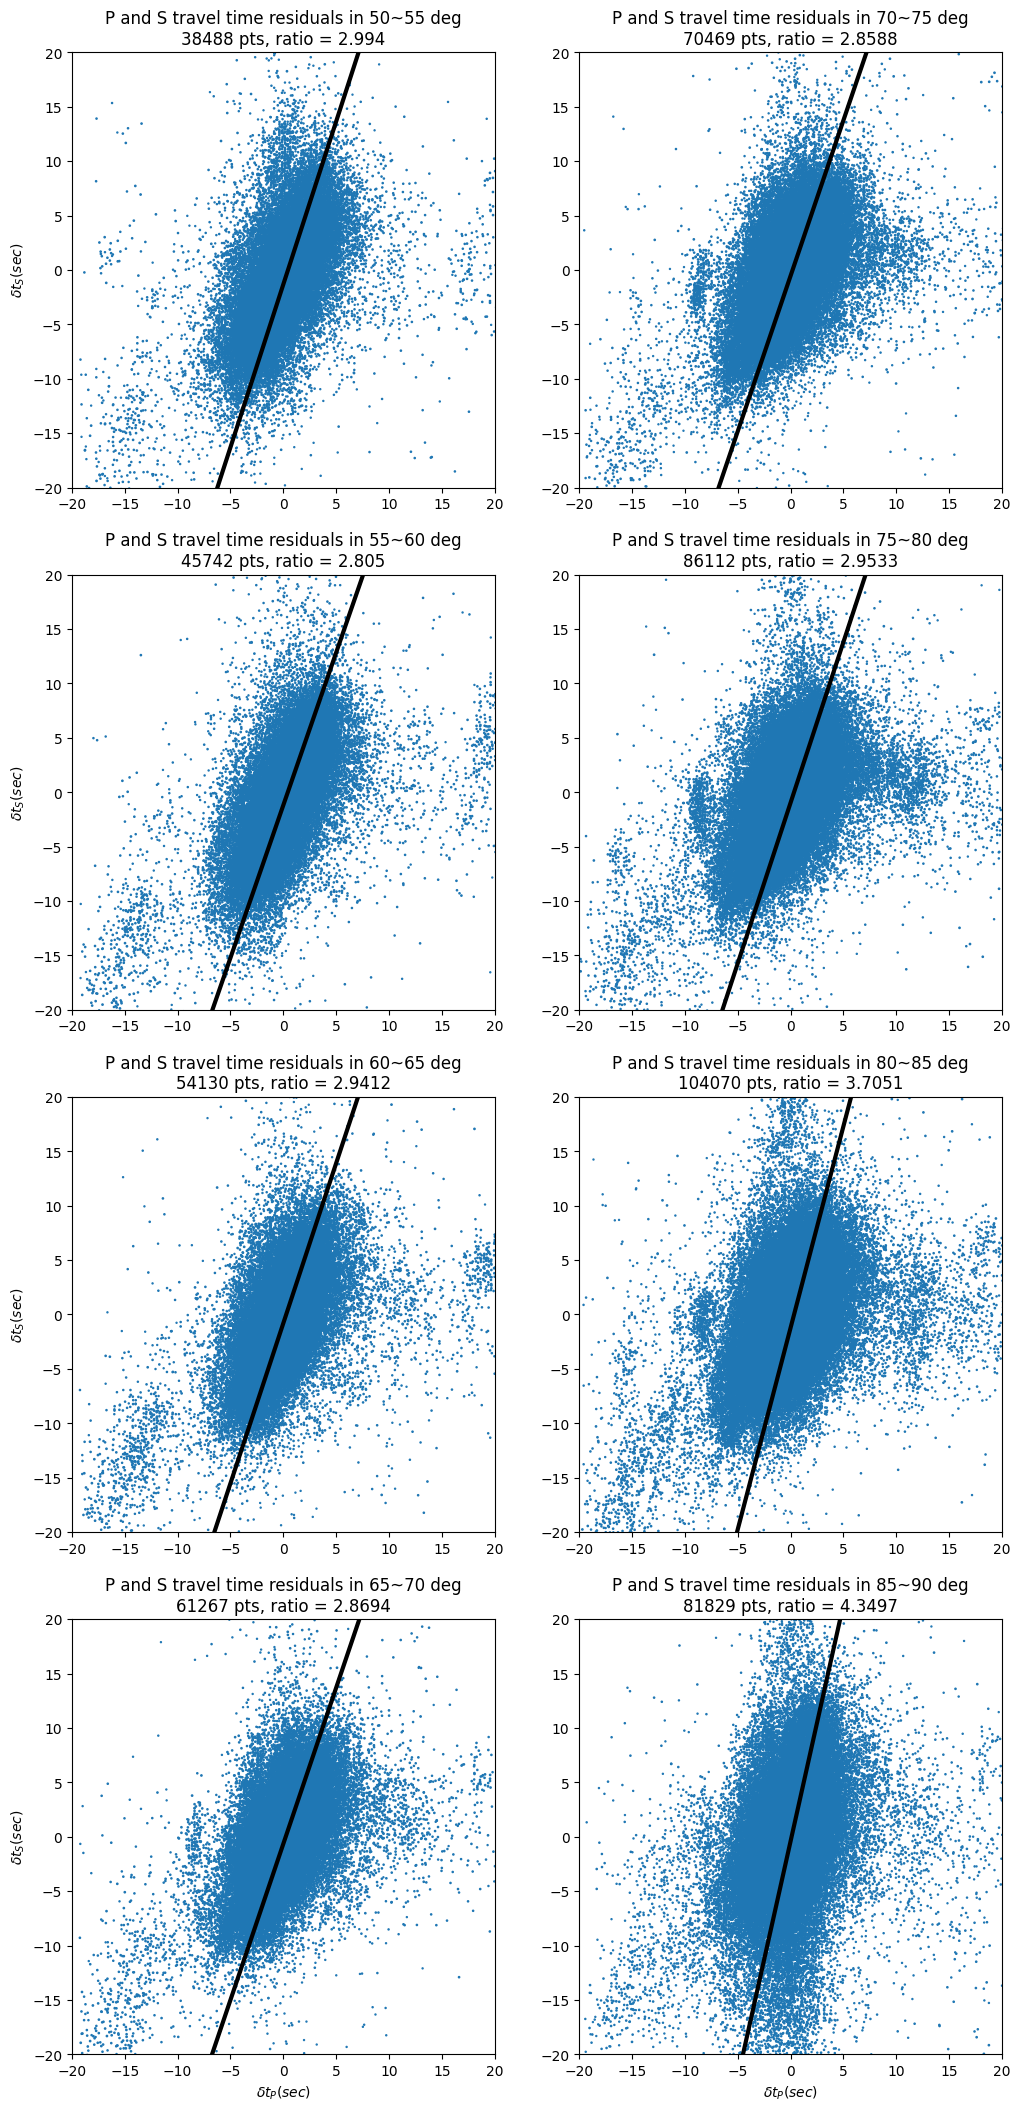

In [4]:
import matplotlib.pyplot as plt

# plt.cla(); plt.clf()
plt.figure(figsize=(12,26))
plt.subplot(421); plot_ratio(get_p_table, get_s_table, (50, 55), x_dep_y=True, x_label=False)
plt.subplot(423); plot_ratio(get_p_table, get_s_table, (55, 60), x_dep_y=True, x_label=False)
plt.subplot(425); plot_ratio(get_p_table, get_s_table, (60, 65), x_dep_y=True, x_label=False)
plt.subplot(427); plot_ratio(get_p_table, get_s_table, (65, 70), x_dep_y=True)
plt.subplot(422); plot_ratio(get_p_table, get_s_table, (70, 75), x_dep_y=True, x_label=False, y_label=False)
plt.subplot(424); plot_ratio(get_p_table, get_s_table, (75, 80), x_dep_y=True, x_label=False, y_label=False)
plt.subplot(426); plot_ratio(get_p_table, get_s_table, (80, 85), x_dep_y=True, x_label=False, y_label=False)
plt.subplot(428); plot_ratio(get_p_table, get_s_table, (85, 90), x_dep_y=True, y_label=False)
plt.subplots_adjust(hspace=0.2)
plt.show()

47276 points fit the conditions
79715 points fit the conditions
56312 points fit the conditions
85177 points fit the conditions
67088 points fit the conditions
92740 points fit the conditions
77180 points fit the conditions
98717 points fit the conditions
90068 points fit the conditions
113681 points fit the conditions
114105 points fit the conditions
139676 points fit the conditions
141698 points fit the conditions
169889 points fit the conditions
137753 points fit the conditions
140893 points fit the conditions


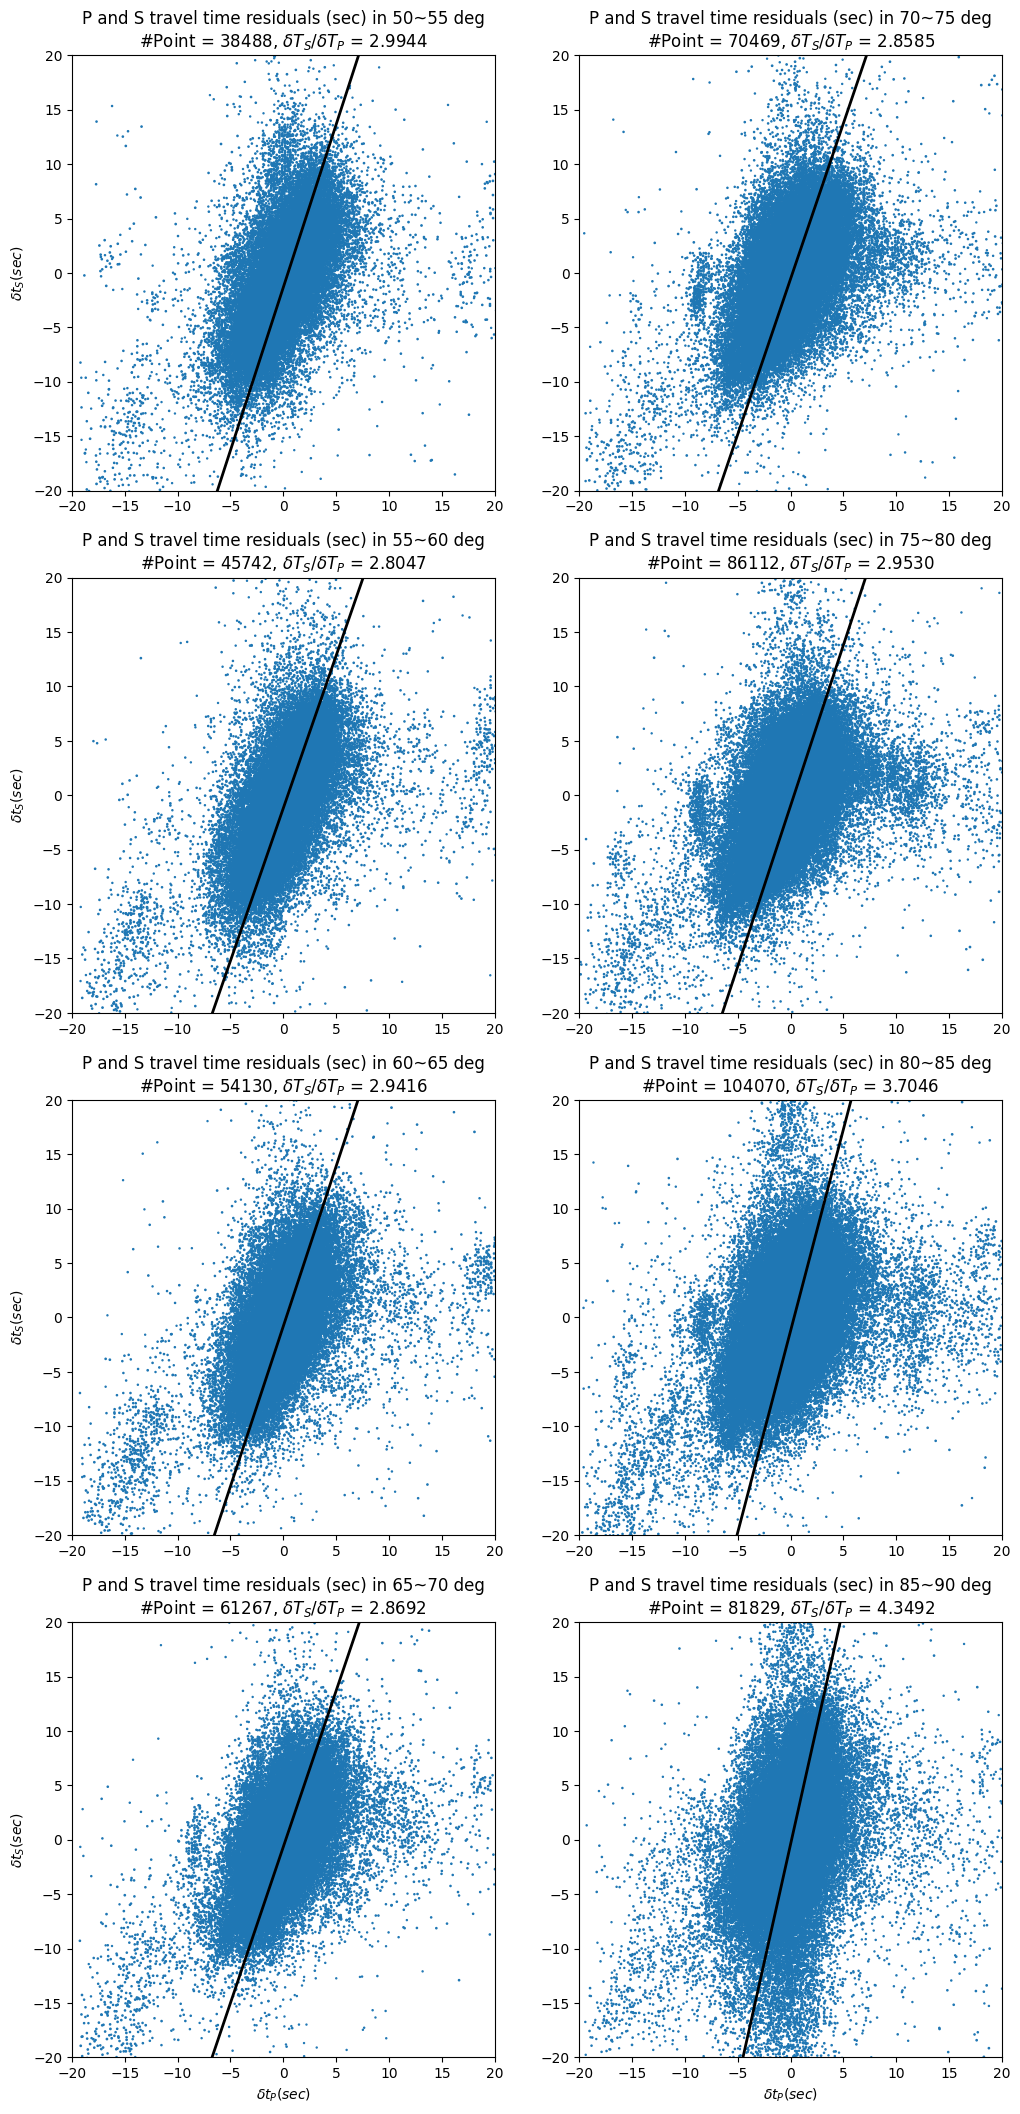

In [6]:
import matplotlib.pyplot as plt

# plt.cla(); plt.clf()
plt.figure(figsize=(12,26))
plt.subplot(421); plot_ratio(get_p_table, get_s_table, (50, 55), x_dep_y=True, x_label=False)
plt.subplot(423); plot_ratio(get_p_table, get_s_table, (55, 60), x_dep_y=True, x_label=False)
plt.subplot(425); plot_ratio(get_p_table, get_s_table, (60, 65), x_dep_y=True, x_label=False)
plt.subplot(427); plot_ratio(get_p_table, get_s_table, (65, 70), x_dep_y=True)
plt.subplot(422); plot_ratio(get_p_table, get_s_table, (70, 75), x_dep_y=True, x_label=False, y_label=False)
plt.subplot(424); plot_ratio(get_p_table, get_s_table, (75, 80), x_dep_y=True, x_label=False, y_label=False)
plt.subplot(426); plot_ratio(get_p_table, get_s_table, (80, 85), x_dep_y=True, x_label=False, y_label=False)
plt.subplot(428); plot_ratio(get_p_table, get_s_table, (85, 90), x_dep_y=True, y_label=False)
plt.subplots_adjust(hspace=0.2)
plt.show()

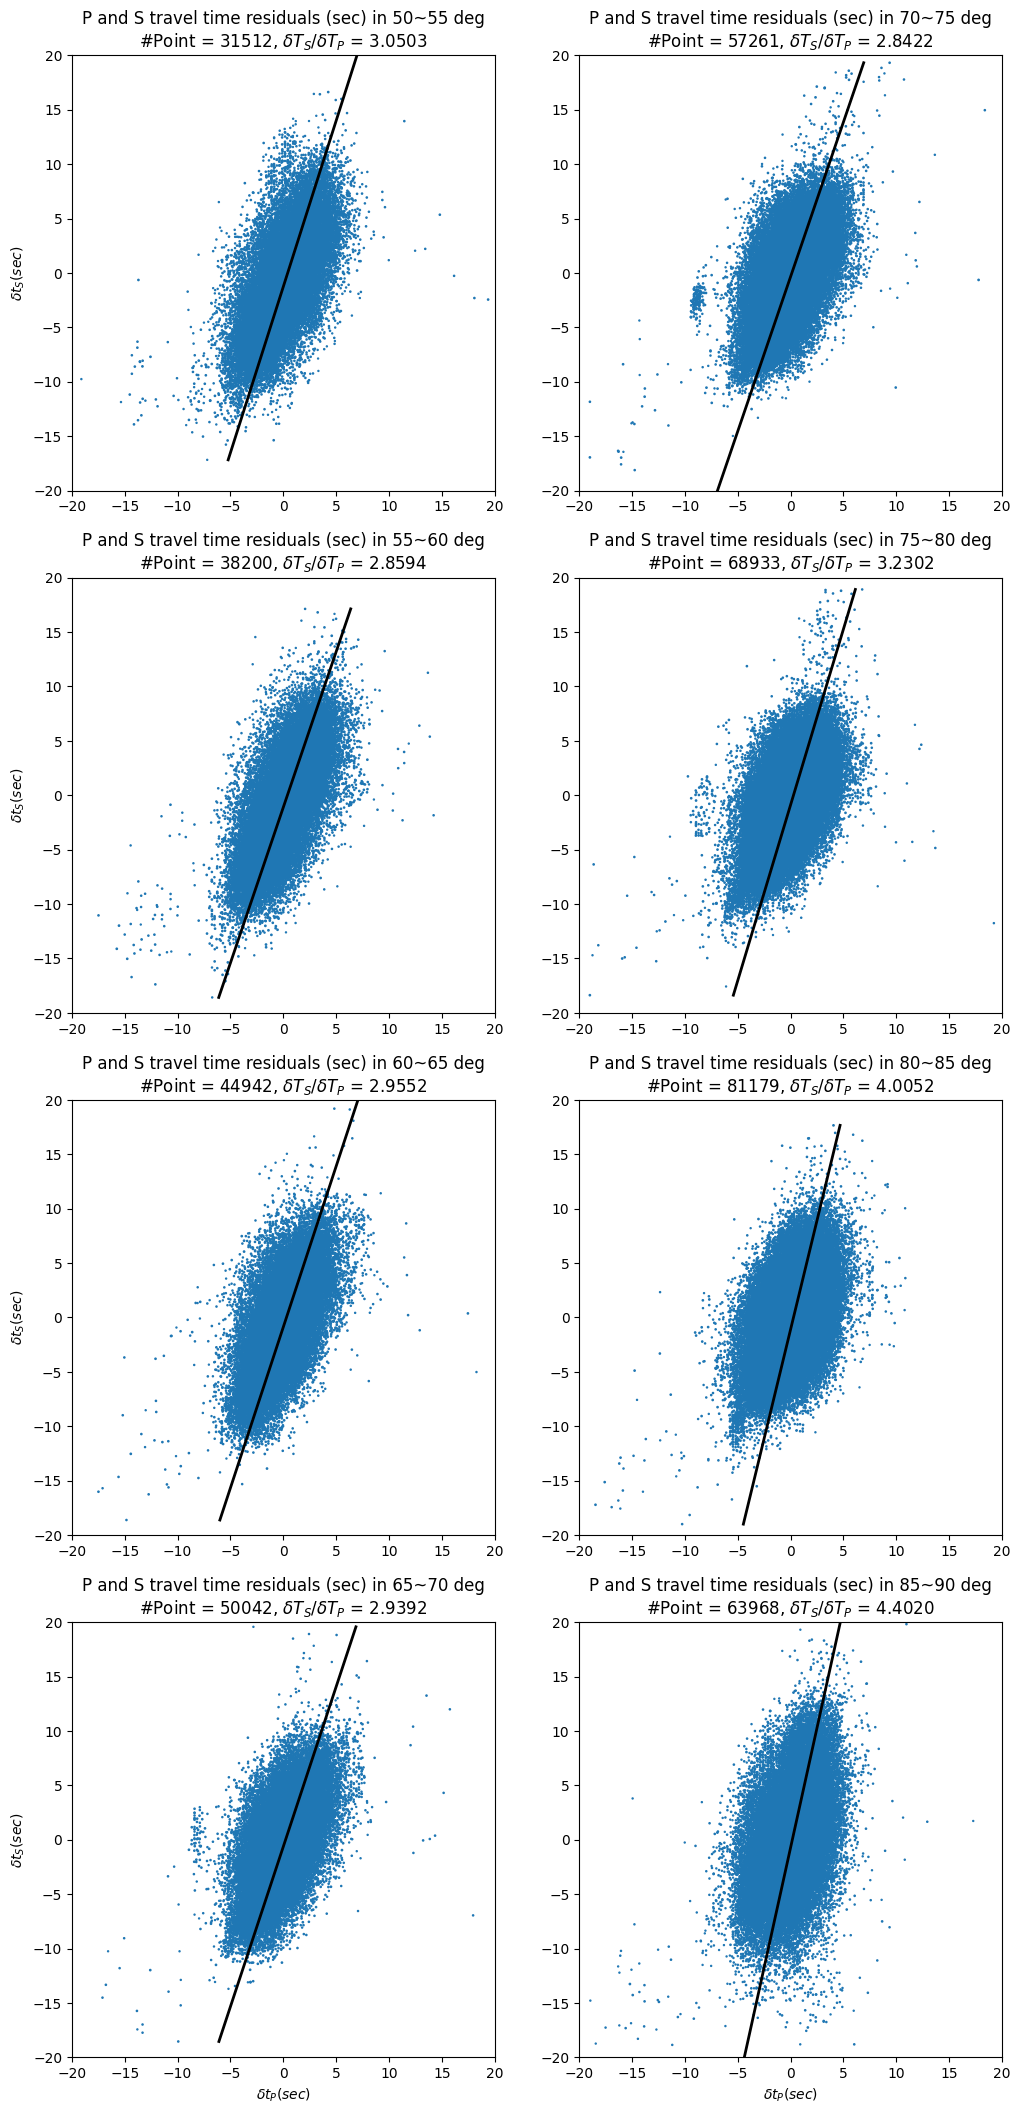

In [7]:
from IPython.display import Image
Image("qc_vpvs.50-90.png")

----
### DATA VISUALIZATION
###### FREQUENCY ANALYSIS
----

In [6]:
from export_catalog import plot_depthslice, plot_ratio
p_thres = 0.7
s_thres = 0.5
gcarc_range = (0, 180)

p_table = plot_depthslice(phase = 'p',
            value = 'anomaly_rev',
            gcarc_range = gcarc_range,
            fidelity_func = lambda p: p-p_thres,
            value_constraint = lambda x: abs(x)<20,
            raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
            summary_ray=True,
            demean=True,
            plot=False
        )
s_table = plot_depthslice(phase = 's',
    value = 'anomaly_rev',
    gcarc_range = gcarc_range,
    fidelity_func = lambda p: p-s_thres,
    value_constraint = lambda x: abs(x)<30,
    raw_filename = 'updeANMO_shift5_catalog_*_plot.pkl',
    summary_ray=True,
    demean=True,
    plot=False
)

get_p_table_rev = lambda gcarc_range: p_table.drop('anomaly', axis='columns').rename(columns={'anomaly_rev': 'anomaly'})
get_p_table_isc = lambda gcarc_range: p_table.drop('anomaly', axis='columns').rename(columns={'anomaly_isc': 'anomaly'})
get_s_table_rev = lambda gcarc_range: s_table.drop('anomaly', axis='columns').rename(columns={'anomaly_rev': 'anomaly'})
get_s_table_isc = lambda gcarc_range: s_table.drop('anomaly', axis='columns').rename(columns={'anomaly_isc': 'anomaly'})

Processing rays: 100%|██████████| 111901/111901 [01:16<00:00, 1459.95it/s]


10701 outliers are removed
101200 points fit the conditions


Processing rays: 100%|██████████| 3287/3287 [00:01<00:00, 3022.80it/s]


137 outliers are removed
3150 points fit the conditions


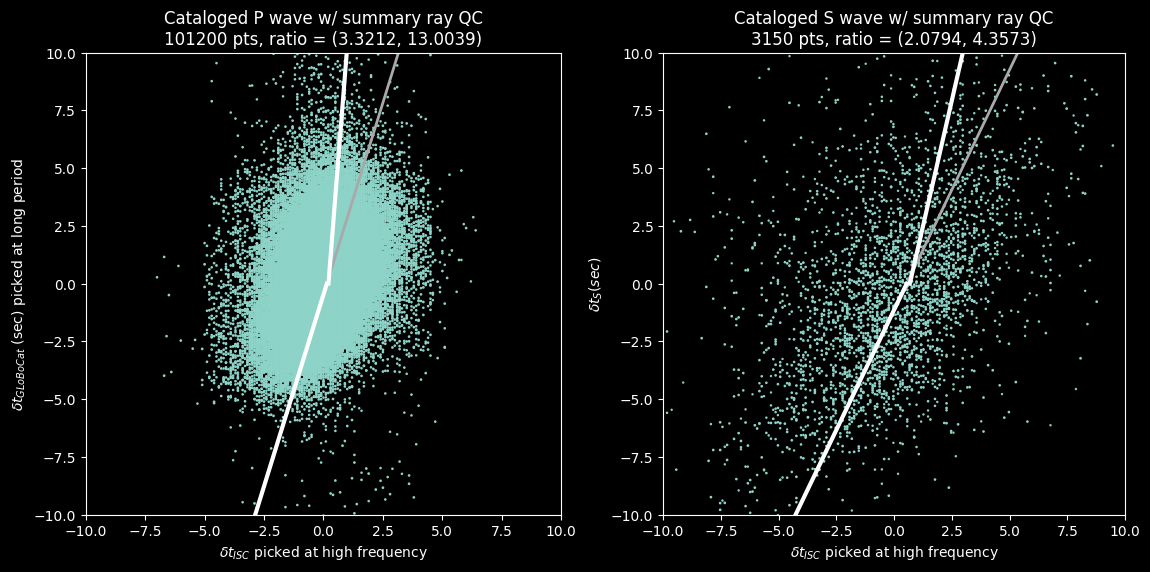

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13.5,6))
plt.subplot(121)
plot_ratio(get_p_table_isc, get_p_table_rev, (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='$\delta t_{ISC}$ picked at high frequency',
    y_label='$\delta t_{GLoBoCat}$ (sec) picked at long period',
    title='Cataloged P wave w/ summary ray QC\n')
plt.subplot(122)
plot_ratio(get_s_table_isc, get_s_table_rev, (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='$\delta t_{ISC}$ picked at high frequency',
    title='Cataloged S wave w/ summary ray QC\n')
plt.gca().set_aspect('equal')
plt.savefig('slope_isc_qc.png')

111901 points fit the conditions
111901 points fit the conditions
2541 points fit the conditions
2541 points fit the conditions


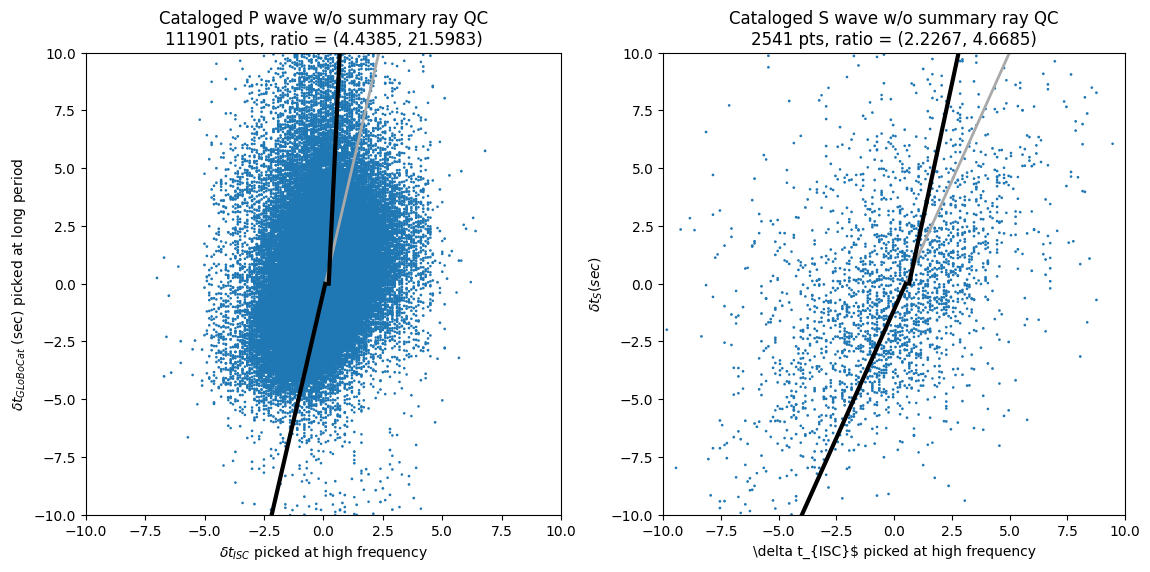

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13.5,6))
plt.subplot(121)
plot_ratio(get_p_table_isc, get_p_table_rev, (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='$\delta t_{ISC}$ picked at high frequency',
    y_label='$\delta t_{GLoBoCat}$ (sec) picked at long period',
    title='Cataloged P wave w/o summary ray QC\n')
plt.subplot(122)
plot_ratio(get_s_table_isc, get_s_table_rev, (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='\delta t_{ISC}$ picked at high frequency',
    title='Cataloged S wave w/o summary ray QC\n')
plt.gca().set_aspect('equal')
plt.savefig('slope_isc_noqc.png')

Processing rays: 100%|██████████| 111901/111901 [01:39<00:00, 1120.54it/s]


10701 outliers are removed
101200 points fit the conditions


Processing rays: 100%|██████████| 111901/111901 [01:29<00:00, 1254.69it/s]


10701 outliers are removed
101200 points fit the conditions


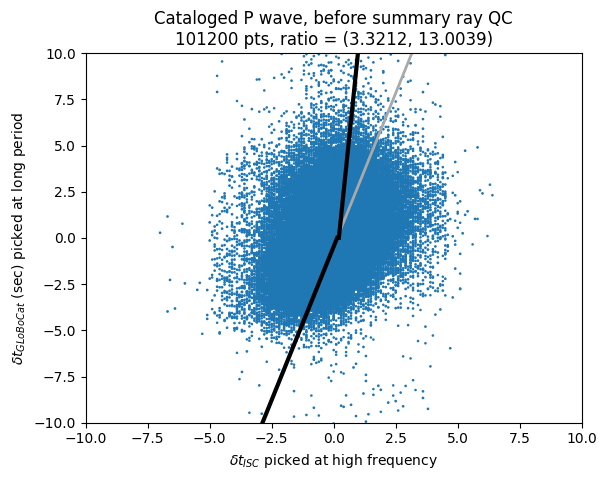

In [7]:
rev_p_table = plot_ratio(get_p_table_isc, get_p_table_rev, (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='$\delta t_{ISC}$ picked at high frequency',
    y_label='$\delta t_{GLoBoCat}$ (sec) picked at long period',
    title='Cataloged P wave, before summary ray QC\n')

----
### DEV
----

In [ ]:
def get_isc_dataframe(self, include_id=False, xml_path=None, load_station_dict=None) -> pd.DataFrame:
    if not hasattr(self, 'station_dict'):
        if load_station_dict and os.path.exists(load_station_dict):
            with open(load_station_dict, 'r') as f:
                self.station_dict = json.load(f)
        else:
            self.station_dict = get_station_dict(xml_path)
    return pd.DataFrame([flatten_list([
                        arrival.resource_id.id.split('-')[-3].split('_')[:2],
                        arrival.phase,
                        round(arrival.time_residual, 2),
                        arrival.pick_id.get_referred_object().time_errors.confidence_level,
                        round(arrival.distance, 4),
                        round(arrival.azimuth, 2),
                        round(arrival.pick_id.get_referred_object().backazimuth, 2),
                        list(midpoint(GeoPoint(
                                lat = ev.preferred_origin().latitude,
                                lon = ev.preferred_origin().longitude
                            ), GeoPoint(
                                lat = self.station_dict[f"{'.'.join(arrival.resource_id.id.split('-')[-3].split('_')[:2])}"]['latitude'],
                                lon = self.station_dict[f"{'.'.join(arrival.resource_id.id.split('-')[-3].split('_')[:2])}"]['longitude']
                            )).get_latlon('deg', precision=3)
                        ),
                        arrival.resource_id.id.split('/')[-1] if include_id else []
                    ]) for ev in self for arrival in ev.preferred_origin().arrivals ],
                # columns=['network', 'station', 'phase', 'time_residual', 'probability','distance', 'azimuth', 'backazimuth', 'midpoint_lat', 'midpoint_lon', 'arrival_id'],
                columns=['network', 'station', 'phase', 'anomaly', 'probability','gcarc', 'azimuth', 'backazimuth', 'turning_lat', 'turning_lon', 'arrival_id'][:(None if include_id else -1)],
                )

In [19]:
old_version = "1.0-b.3"
new_version = "1.0-b.3"
datalist_dir = "/Users/junsu/Documents/data_gcmt.pkl"
event_filter =  ""
filename_subfix = ""
result_csv_filenames = glob.glob("./updeANMO_shift5_pred_catalog_*/*_outputs/X_prediction_results.csv")

if not os.path.exists(f"./globocat_{old_version}.xml"):
    globocat = Catalog()
else:
    globocat = read_events(f"./globocat_{old_version}.xml")

globocat.resource_id=str(f"quakeml:jun.su/globocat_{new_version}")
globocat.creation_info=CreationInfo(author="Jun Su", version=new_version, creation_time=UTCDateTime.now())

with open(datalist_dir, 'rb') as f: datalist = pickle.load(f)
df = update_dataframe(globocat, datalist, result_csv_filenames, new_version)

'Progress: [2225/2225] [100.0%] [====================>]'

In [21]:
df.to_pickle(f"./globocat_{new_version}.pkl")

In [17]:
globocat

0 Event(s) in Catalog:


In [34]:
for event in globocat[:10]:
    # print()
    isc_event_path = f"quakeml/P/{event.preferred_origin().time}.xml"
    isc_events = read_events(isc_event_path)
    if len(isc_events) == 0: raise Exception(f"No event in ISC catalog:", isc_event_path)
    elif len(isc_events) > 1:raise Exception(f"More than one events in ISC catalog:", isc_event_path)
    
    isc_event = isc_events[0]
    if len(isc_event.origins) == 0: raise Exception(f"No origin in ISC catalog:", isc_event_path)
    elif len(isc_event.origins) > 1:raise Exception(f"More than one origins in ISC catalog:", isc_event_path)
    
    
    # isc_events

In [49]:
print(dir(globocat[0].picks[0]))

['_MutableMapping__marker', '__abstractmethods__', '__bool__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_cast_type', '_containers', '_pretty_str', '_properties', '_property_dict', '_property_keys', '_repr_pretty_', '_types', 'backazimuth', 'backazimuth_errors', 'clear', 'comments', 'copy', 'creation_info', 'defaults', 'do_not_warn_on', 'evaluation_mode', 'evaluation_status', 'filter_id', 'get', 'horizontal_slowness', 'horizontal_slowness_errors', 'item', 'items', 'key', 'keys', 'method_id', 'onset', 'phase_hint', 

In [44]:
arrival_ids = [arrival.resource_id for arrival in globocat[0].origins[0].arrivals]

In [71]:
event_id, station_info, phase = arrival_ids[0].id.rsplit('-', 3)[:-1]
network_code, station_code = station_info.split('_')[:-1]

In [74]:
arrival_ids[0].id

'quakeml:jun.su/globocat/evct-2020-03-20T01:33:15.900Z-TW_SSLB_LH-P-PREM'

In [2]:
# from obspy import read_events
def get_isc_event(isc_event_path):
    isc_events = read_events(isc_event_path)
    if len(isc_events) == 0: return None
    elif len(isc_events) > 1:raise Exception(f"More than one events in ISC catalog:", isc_event_path)
    else: isc_event = isc_events[0]
    if len(isc_event.origins) == 0: raise Exception(f"No origin in ISC catalog:", isc_event_path)
    elif len(isc_event.origins) > 1:raise Exception(f"More than one origins in ISC catalog:", isc_event_path)
    return isc_event

count = 0
for event in globocat:
    count+=1
    print(f'event:{count}/{len(globocat)}', end='\r')
    isc_p_event = get_isc_event(f"quakeml/P/{UTCDateTime('-'.join(event.resource_id.id.split('-')[1:]), precision=6)}.xml")
    isc_s_event = get_isc_event(f"quakeml/S/{UTCDateTime('-'.join(event.resource_id.id.split('-')[1:]), precision=6)}.xml")
    # print(isc_p_event)
    if isc_p_event: event.picks += isc_p_event.picks 
    if isc_s_event: event.picks += isc_s_event.picks 
    if isc_p_event:
        if isc_s_event: isc_p_event.origins[0].arrivals += isc_s_event.origins[0].arrivals
        event.origins.append(isc_p_event.origins[0])
    elif isc_s_event: event.origins.append(isc_s_event.origins[0])
    
# globocat[0].origins[1]

In [11]:
from tqdm import tqdm

def find_related_isc_arrival(arrival_id):
    event_id, station_info, phase = arrival_id.rsplit('/',1)[-1].rsplit('-', 3)[:-1]
    network_code, station_code = station_info.split('_')[:-1]
    event = ResourceIdentifier(id=event_id).get_referred_object()
    for origin in event.origins:
        if origin.creation_info and origin.creation_info.author == 'ISC':
            for isc_arrival in origin.arrivals:
                if isc_arrival.phase == phase and isc_arrival.pick_id.get_referred_object().waveform_id.station_code == station_code:
                    return isc_arrival
    return None
anomaly_isc = lambda arrival_id: find_related_isc_arrival(arrival_id).time_residual if find_related_isc_arrival(arrival_id) else np.NaN
anomaly_rev = lambda arrival_id: ( anomaly_isc(arrival_id)
                                    + (ResourceIdentifier(arrival_id).get_referred_object().pick_id.get_referred_object().time
                                    - find_related_isc_arrival(arrival_id).pick_id.get_referred_object().time) ) if find_related_isc_arrival(arrival_id) else np.NaN
                                    # ) if find_related_isc_arrival(arrival_id) else np.NaN

df = pd.read_pickle("updeANMO_shift5_catalog_2020_plot.pkl")
res = pd.DataFrame([['quakeml:jun.su/globocat/'+arrival_id, round(anomaly_rev('quakeml:jun.su/globocat/'+arrival_id), 2), anomaly_isc('quakeml:jun.su/globocat/'+arrival_id)] for arrival_id in tqdm(df['arrival_id'].values, desc="Processing arrivals")],
            columns=['arrival_id', 'anomaly_rev', 'anomaly_isc']
            )

KeyboardInterrupt: 

In [74]:
'evct-2020-03-20T01:33:15.900Z-AK_HOM_LH-S-PREM'.rsplit('/',1)[-1]

'evct-2020-03-20T01:33:15.900Z-AK_HOM_LH-S-PREM'

In [25]:
res.loc[res['anomaly_rev'].notnull()]

arrival_id  anomaly_rev  \
25      quakeml:jun.su/globocat/evct-2020-03-20T01:33:...         2.72   
27      quakeml:jun.su/globocat/evct-2020-03-20T01:33:...         4.93   
28      quakeml:jun.su/globocat/evct-2020-03-20T01:33:...         2.80   
29      quakeml:jun.su/globocat/evct-2020-03-20T01:33:...         0.40   
30      quakeml:jun.su/globocat/evct-2020-03-20T01:33:...         1.49   
...                                                   ...          ...   
272856  quakeml:jun.su/globocat/evct-2020-09-01T07:01:...         9.37   
272868  quakeml:jun.su/globocat/evct-2020-09-01T07:01:...       -54.58   
272942  quakeml:jun.su/globocat/evct-2020-12-29T16:21:...         5.00   
272944  quakeml:jun.su/globocat/evct-2020-12-29T16:21:...         7.69   
273029  quakeml:jun.su/globocat/evct-2020-12-27T06:37:...         5.11   

        anomaly_isc  
25             -0.2  
27              2.5  
28              0.8  
29             -7.2  
30             -0.1  
...             ...  
272856          1.9  
272868          1.8  
272942          0.9  
272944          1.9  
273029         -0.3  

[10298 rows x 3 columns]

In [68]:
ResourceIdentifier('quakeml:jun.su/globocat/evct-2020-03-20T01:33:15.900Z-AK_HOM_LH-S-PREM').get_referred_object()

Arrival
	    resource_id: ResourceIdentifier(id="quakeml:jun.su/globocat/evct-2020-03-20T01:33:15.900Z-AK_HOM_LH-S-PREM")
	        pick_id: ResourceIdentifier(id="quakeml:jun.su/globocat/evct-2020-03-20T01:33:15.900Z-AK_HOM_LH-S")
	          phase: 'S'
	        azimuth: 26.18281150172374
	       distance: 79.57548583316988
	  time_residual: 1.139269199673663
	 earth_model_id: ResourceIdentifier(id="smi:local/prem")

In [37]:
anomaly_rev()

AttributeError: 'NoneType' object has no attribute 'pick_id'

Processing rays: 100%|██████████| 111901/111901 [01:28<00:00, 1260.29it/s]


10701 outliers are removed
101200 points fit the conditions


Processing rays: 100%|██████████| 111901/111901 [01:34<00:00, 1184.37it/s]


10701 outliers are removed
101200 points fit the conditions


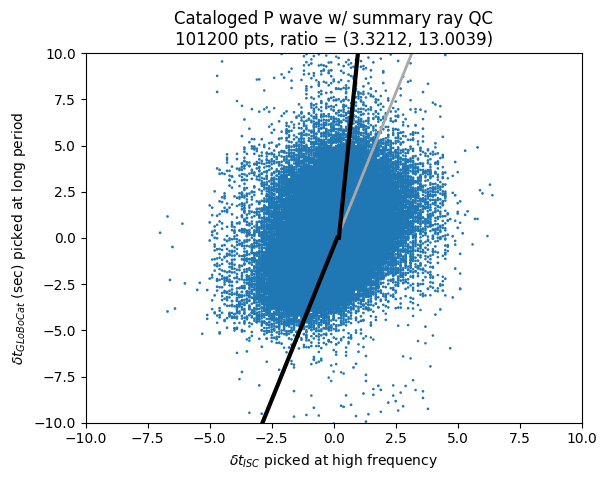

In [13]:
df_rev = plot_ratio(get_p_table_isc, get_p_table_rev, (0, 180), [-10,10], [-10,10],
    demean=True, x_dep_y=True, slope_two_sections=True,
    x_label='$\delta t_{ISC}$ picked at high frequency',
    y_label='$\delta t_{GLoBoCat}$ (sec) picked at long period',
    title='Cataloged P wave w/ summary ray QC\n')

In [38]:
import numpy as np
np.corrcoef(df_rev['anomaly_isc'].values, df_rev['anomaly_rev'].values)[0,1]


0.23073099581418355

In [119]:


df_rev['event_time'] = [ arrival_id.rsplit('-',3)[0].rsplit('/',1)[1][5:] for arrival_id in df_rev['arrival_id'].values]

In [126]:
df_rev.loc[df_rev['anomaly_rev']>6.5].sort_values('event_time').to_csv('test_outlier.csv')

In [ ]:
df.to_csv('globocat-1.2.0.csv')

In [129]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('test_outlier.csv')

# Calculate and display frequency of probability2 values
probability2_freq = df['event_time'].value_counts().sort_index().sort_values()
print("\nFrequency of event_time values:")
print(probability2_freq)


Frequency of event_time values:
2016-05-18T16:46:49.200Z     1
2018-11-30T17:29:34.700Z     1
2019-05-09T22:43:25.100Z     1
2019-05-18T01:51:34.200Z     1
2019-11-26T02:54:18.200Z     1
                            ..
2010-06-12T19:27:00.400Z    14
2012-09-30T16:31:44.500Z    15
2013-01-05T08:58:31.500Z    23
2012-11-11T01:12:55.500Z    23
2012-10-28T03:04:37.200Z    43
Name: event_time, Length: 214, dtype: int64


In [100]:
import pandas as pd
arrival_id = df_rev.loc[df_rev['anomaly_rev']>7, 'arrival_id'].values[4]
# if arrival_id.rsplit()
event_id, station_info, phase, ref_model = arrival_id.rsplit('-',3)
srctime = event_id.rsplit('/',1)[1][5:]
# if station

if (station_info[:2] == 'US') or (station_info[:2] == 'TA'):
    predict_result_path = f'updeANMO_shift5_pred_catalog_usta_{srctime[:4]}/{station_info.split("_")[1]}_outputs/X_prediction_results.csv'
else:
    predict_result_path = f'updeANMO_shift5_pred_catalog_not_usta_{srctime[:4]}/{station_info.split("_")[1]}_outputs/X_prediction_results.csv'

ref_df = pd.read_csv(predict_result_path)
file_name_list = ref_df['file_name'].values
record_match = ref_df.loc[[file_name.rsplit('_',1)[1] == srctime for file_name in ref_df['file_name'].values]]
record_match

file_name network station instrument_type  \
138  TLY_II_LH_2010-06-12T19:27:00.400Z      II    TLY               LH   

     station_lat  station_lon  station_elv           signal_start_time  \
138      51.6807     103.6438            0  2010-06-12 19:35:10.277382   

                signal_end_time  detection_probability  detection_uncertainty  \
138  2010-06-12 19:44:21.277382                   0.99                    NaN   

                 p_arrival_time  p_probability  p_uncertainty  p_snr  \
138  2010-06-12 19:35:11.527382           0.95            NaN   40.1   

                 s_arrival_time  s_probability  s_uncertainty  s_snr  
138  2010-06-12 19:41:43.277382           0.49            NaN   13.0

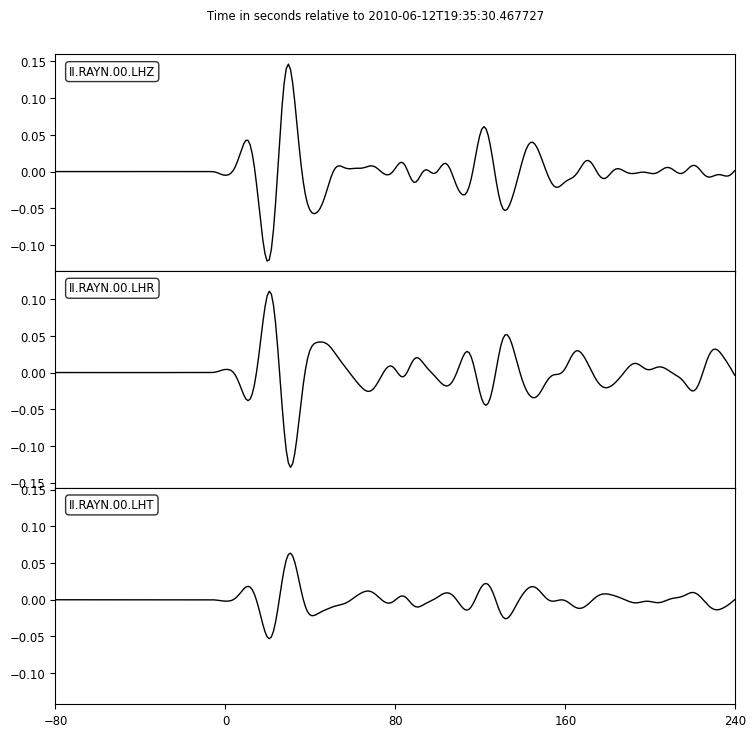

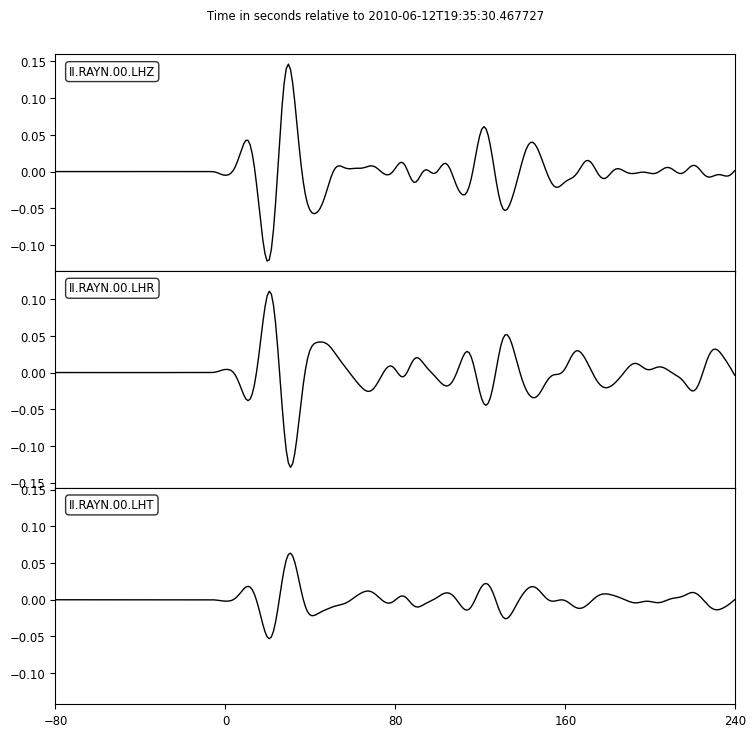

In [95]:
import obspy
st = obspy.read('/Users/junsu/Downloads/II.RAYN.LH.obspy')
p_arrival_time = obspy.UTCDateTime(record_match['p_arrival_time'].values[0])
st.plot(type='relative', reftime= p_arrival_time, starttime= p_arrival_time - 80, endtime= p_arrival_time + 240)

In [31]:
from tqdm import tqdm

def find_related_isc_arrival(arrival_id):
    event_id, station_info, phase = arrival_id.rsplit('-', 3)[:-1]
    network_code, station_code = station_info.split('_')[:-1]
    event = ResourceIdentifier(id=event_id).get_referred_object()
    for origin in event.origins:
        if origin.creation_info and origin.creation_info.author == 'ISC':
            for isc_arrival in origin.arrivals:
                if isc_arrival.phase == phase and isc_arrival.pick_id.get_referred_object().waveform_id.station_code == station_code:
                    return isc_arrival
    return None
anomaly_isc = lambda arrival_id: find_related_isc_arrival(arrival_id).time_residual if find_related_isc_arrival(arrival_id) else np.NaN
anomaly_rev = lambda arrival_id: ( anomaly_isc(arrival_id)
                                    + ResourceIdentifier(arrival_id).get_referred_object().pick_id.get_referred_object().time
                                    - find_related_isc_arrival(arrival_id).pick_id.get_referred_object().time ) if find_related_isc_arrival(arrival_id) else np.NaN

df = pd.read_pickle("updeANMO_shift5_catalog_2020_plot.pkl")
res = pd.DataFrame([[arrival_id, anomaly_isc(arrival_id), anomaly_isc(arrival_id)] for arrival_id in tqdm(df['arrival_id'].values, desc="Processing arrivals")],
            columns=['arrival_id', 'anomaly_rev', 'anomaly_isc']
            )

KeyboardInterrupt: 

In [20]:
# find_related_isc_arrival('evct-2020-03-20T01:33:15.900Z-TW_SSLB_LH-P-PREM')
arrival_id = "evct-2020-03-20T01:33:15.900Z-II_RAYN_LH-P-PREM"
event_id, station_info, phase = arrival_id.rsplit('-', 3)[:-1]
network_code, station_code = station_info.split('_')[:-1]
event = ResourceIdentifier(id=event_id).get_referred_object()
event

Event:	2020-03-20T01:33:15.900000Z | +28.510,  +87.420 | 5.69 Mw

	         resource_id: ResourceIdentifier(id="evct-2020-03-20T01:33:15.900Z")
	          event_type: 'earthquake'
	 preferred_origin_id: ResourceIdentifier(id="smi:local/gcmt202003200133A")
	                ---------
	               picks: 1005 Elements
	             origins: 2 Elements
	          magnitudes: 1 Elements

In [19]:
# df.loc[df['station']=='PSI']
df

network station phase  anomaly  probability    gcarc  azimuth  \
0           TW    SSLB     P     3.06         0.77  30.4206    91.04   
1           TW    SSLB     S     5.12         0.40  30.4206    91.04   
2           II    RAYN     P     2.47         0.88  37.8735   272.38   
3           II    RAYN     S    -7.12         0.75  37.8735   272.38   
4           AK    GAMB     P    -6.06         0.19  69.3437    27.70   
...        ...     ...   ...      ...          ...      ...      ...   
273137      TA    G25K     P    51.33         0.29  74.9493     2.17   
273138      TA    G25K     S     5.06         0.85  74.9493     2.17   
273139      US    BINY     P    -1.05         0.11  80.3914   317.15   
273140      TA    L15K     S     6.23         0.43  78.7266     9.85   
273141      TA    P33M     S     3.47         0.61  81.3789   356.00   

        backazimuth  turning_lat  turning_lon  \
0            286.19       27.146      104.536   
1            286.19       27.146      104.536   
2             73.29       27.594       65.995   
3             73.29       27.594       65.995   
4            292.69       56.606      116.037   
...             ...          ...          ...   
273137       355.70       75.704       44.529   
273138       355.70       75.704       44.529   
273139        45.99       57.688      -15.862   
273140       343.61       75.840       65.457   
273141         6.32       78.623       25.889   

                                             arrival_id  
0       evct-2020-03-20T01:33:15.900Z-TW_SSLB_LH-P-PREM  
1       evct-2020-03-20T01:33:15.900Z-TW_SSLB_LH-S-PREM  
2       evct-2020-03-20T01:33:15.900Z-II_RAYN_LH-P-PREM  
3       evct-2020-03-20T01:33:15.900Z-II_RAYN_LH-S-PREM  
4       evct-2020-03-20T01:33:15.900Z-AK_GAMB_LH-P-PREM  
...                                                 ...  
273137  evct-2020-12-27T06:37:34.800Z-TA_G25K_LH-P-PREM  
273138  evct-2020-12-27T06:37:34.800Z-TA_G25K_LH-S-PREM  
273139  evct-2020-12-27T06:37:34.800Z-US_BINY_LH-P-PREM  
273140  evct-2020-12-27T06:37:34.800Z-TA_L15K_LH-S-PREM  
273141  evct-2020-12-27T06:37:34.800Z-TA_P33M_LH-S-PREM  

[273142 rows x 11 columns]

In [24]:
for origin in event.origins:
    if origin.creation_info and origin.creation_info.author == 'ISC':
        # print('ISC')
        for isc_arrival in origin.arrivals:
            print(isc_arrival.phase, station_code, isc_arrival.pick_id.get_referred_object().waveform_id.station_code, network_code, isc_arrival.pick_id.get_referred_object().waveform_id.network_code)
            if isc_arrival.phase == phase and isc_arrival.pick_id.get_referred_object().waveform_id.station_code == station_code:
                print(isc_arrival)
                break

P RAYN AAK II IR
P RAYN TDK II IR
P RAYN MKAR II IR
P RAYN PALK II IR
P RAYN KURBB II IR
P RAYN BSI II IR
P RAYN SONM II IR
P RAYN ULN II IR
P RAYN LHMI II IR
P RAYN ZALV II IR
P RAYN KULM II IR
P RAYN KCSI II IR
P RAYN BVAR II IR
P RAYN PSI II IR
P RAYN GSI II IR
P RAYN MNSI II IR
P RAYN MYKOM II IR
P RAYN BKNI II IR
P RAYN PPI II IR
P RAYN PDSI II IR
P RAYN DSRI II IR
P RAYN JMBI II IR
P RAYN TGY II IR
P RAYN MASI II IR
P RAYN KSRS II IR
P RAYN SBUM II IR
P RAYN KKM II IR
P RAYN MDSI II IR
P RAYN GNI II IR
P RAYN TPI II IR
P RAYN LWLI II IR
P RAYN KLI II IR
P RAYN JNU II IR
P RAYN KASI II IR
P RAYN KBZ II IR
P RAYN USRK II IR
P RAYN KIV II IR
P RAYN DCPH II IR
P RAYN KLR II IR
P RAYN DBJI II IR
P RAYN NRIK II IR
P RAYN CTJI II IR
P RAYN KPJI II IR
P RAYN BBKI II IR
P RAYN MPSI II IR
P RAYN DAV II IR
P RAYN NGJI II IR
P RAYN PCI II IR
P RAYN SJI II IR
P RAYN MJAR II IR
P RAYN SNJI II IR
P RAYN MRSI II IR
P RAYN MMSI II IR
P RAYN KMMI II IR
P RAYN PMSI II IR
P RAYN BLJI II IR
P RAYN TT

In [36]:
res

arrival_id  anomaly_rev  \
0       evct-2020-03-20T01:33:15.900Z-TW_SSLB_LH-P-PREM          NaN   
1       evct-2020-03-20T01:33:15.900Z-TW_SSLB_LH-S-PREM          NaN   
2       evct-2020-03-20T01:33:15.900Z-II_RAYN_LH-P-PREM          NaN   
3       evct-2020-03-20T01:33:15.900Z-II_RAYN_LH-S-PREM          NaN   
4       evct-2020-03-20T01:33:15.900Z-AK_GAMB_LH-P-PREM          NaN   
...                                                 ...          ...   
273137  evct-2020-12-27T06:37:34.800Z-TA_G25K_LH-P-PREM          NaN   
273138  evct-2020-12-27T06:37:34.800Z-TA_G25K_LH-S-PREM          NaN   
273139  evct-2020-12-27T06:37:34.800Z-US_BINY_LH-P-PREM          NaN   
273140  evct-2020-12-27T06:37:34.800Z-TA_L15K_LH-S-PREM          NaN   
273141  evct-2020-12-27T06:37:34.800Z-TA_P33M_LH-S-PREM          NaN   

        anomaly_isc  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
273137          NaN  
273138          NaN  
273139          NaN  
273140          NaN  
273141          NaN  

[273142 rows x 3 columns]

In [35]:
res.loc[res['anomaly_rev']==True]

Empty DataFrame
Columns: [arrival_id, anomaly_rev, anomaly_isc]
Index: []